# NO2 Models


## README
### Overview

This project develops different machine learning models to fit NO₂ concentration based on various environmental, land use, and socio-economic features. The goal is to analyze key drivers of NO₂ concentration and get the importance of different features.

### Objective

- Load and clean spatial-temporal pollution datasets.
- Feature engineer variables such as land use, temperature, population, etc.  
- Train and evaluate a predictive model for pollution levels.
- Interpret feature importance to identify key contributing factors.

### Workflow

1. **Data Preparation**
   - Import GeoPackage data (e.g., temperature, NTL, NO₂, land use).
   - Aggregate and align datasets to mesh grid.

2. **Feature Engineering**
   - Create lagged features and neighborhood statistics.
   - Classify cloud categories and normalize variables.

3. **Modeling**
   - Apply **RandomForest** and **XGBoost** methods for NO₂ prediction.
   - Use **feature importance**(from XGBoost and SHAP) for interpretation.
   - Evaluate model with RMSE.

4. **Visualization**
   - Produce plots to show the training and testing process.
   - Produce plots to show the importance of different features.
   


## Init: Prepare Packages and Configuration

In [1]:
# Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm rasterstats
# ! pip install numpy==1.24.4CURR_PATH
# ! pip install libpysal
# ! pip install geopandas libpysal esda matplotlib
# ! pip install seaborn

# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# print(REPO_PATH)

#### Flowchart to build the model

![Toy regression tree](../figures/flowchart.png)

**End-to-end modelling pipeline (what happens behind the scenes)**  

1. **Data ingestion** – We pull raw daily NO₂ readings plus all contextual layers (roads, land-use, population, weather) into one tidy table.  
2. **Feature engineering** – Two smart add-ons enrich the raw data:  
   * *Temporal lags* capture “what happened yesterday” so the model learns persistence.  
   * *Spatial-neighbour features* relay the average NO₂ in the eight surrounding grid cells, letting the model see up-wind spill-over.  
3. **Hyper-parameter tuning** – We run an automated grid search to pick the tree depth, number of trees, learning rate, etc., that minimise validation error.  
4. **Evaluation metrics** – The tuned model is stress-tested on an unseen hold-out set; we track R², RMSE and MAE to ensure real-world accuracy.  
5. **Interpretability outputs** – Once the model passes the accuracy bar, we open the black box:  
   * **SHAP explainability** ranks which features push NO₂ up or down and by how much.  
   * **Elasticities** translate those SHAP values into easy-to-read “% change” statements for decision-makers.

> The diagram above shows these five stages in one glance, from raw data all the way to actionable insights.

## 0 Data Preparing

The following cell made the pre-processing of the data, including:

1) Integrate all the gpkg into a large file with date.

2) Add new features:

    - Yesterday NO2 (1 day lag)

    - Yesterday average NO2 level.

3) Export as parquet file for faster read in the future.

### **Addis Ababa**

In [2]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, datetime

mesh_folder = DATA_PATH / 'addis-mesh-data'
file_paths = sorted(mesh_folder.glob("*.gpkg")) 

all_data = []

for i, path in tqdm(enumerate(file_paths), total=len(file_paths)):
    date = datetime(2023, 1, 1) + timedelta(days=i)
    gdf = gpd.read_file(path)
    gdf["date"] = date
    all_data.append(gdf)

full_add_df = pd.concat(all_data, ignore_index=True)

100%|██████████| 731/731 [00:16<00:00, 45.66it/s]
C:\Users\87383\AppData\Local\Temp\ipykernel_15404\2107820182.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_add_df = pd.concat(all_data, ignore_index=True)


In [ ]:
# import warnings
# from libpysal.weights import KNN

# # Add Yesterday NO2
# full_df.sort_values(["geom_id", "date"], inplace=True)
# full_df["no2_lag1"] = full_df.groupby("geom_id")["no2_mean"].shift(1)

# # Add neighbor no2 data
# sample_gdf = full_df[full_df['date'] == full_df['date'].min()].reset_index(drop=True)
# k_neighbors = 8 

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     w = KNN.from_dataframe(sample_gdf, k=k_neighbors)

# w.transform = 'r'

# geom_id_to_neighbors = {}
# index_to_geom_id = dict(sample_gdf['geom_id'].items())

# for i, neighbors in w.neighbors.items():
#     geom_id = index_to_geom_id[i]
#     neighbor_ids = [index_to_geom_id[j] for j in neighbors]
#     geom_id_to_neighbors[geom_id] = neighbor_ids

# def compute_neighbor_no2(row, df_dict):
#     date = row["date"]
#     geom_id = row["geom_id"]
#     prev_date = date - timedelta(days=1)
#     if prev_date not in df_dict:
#         return None
#     prev_day_df = df_dict[prev_date]
#     neighbors = geom_id_to_neighbors.get(geom_id, [])
#     values = prev_day_df[prev_day_df["geom_id"].isin(neighbors)]["no2_mean"]
#     return values.mean() if not values.empty else None

# df_by_date = {d: gdf for d, gdf in full_df.groupby("date")}
# full_df["no2_neighbor_lag1"] = full_df.apply(lambda row: compute_neighbor_no2(row, df_by_date), axis=1)

## Save the file
# full_df.to_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow", compression="snappy")

Save the file for future use.

In [4]:
full_add_df.columns

Index(['geom_id', 'no2_mean', 'pop_sum_m', 'NTL_mean', 'cloud_category',
       'LST_day_mean', 'landcover_2023', 'tree_cover_a', 'shrubland_a',
       'grassland_a', 'cropland_a', 'built_up_a', 'sparse_veg_a', 'snow_a',
       'water_bod_a', 'wetland_a', 'mangroves_a', 'moss_a', 'unclassified_a',
       'road_len', 'road_share', 'poi_count', 'poi_share',
       'lu_industrial_area', 'lu_industrial_share', 'lu_commercial_area',
       'lu_commercial_share', 'lu_residential_area', 'lu_residential_share',
       'lu_retail_area', 'lu_retail_share', 'lu_farmland_area',
       'lu_farmland_share', 'lu_farmyard_area', 'lu_farmyard_share',
       'road_motorway_len', 'road_trunk_len', 'road_primary_len',
       'road_secondary_len', 'road_tertiary_len', 'road_residential_len',
       'fossil_pp_count', 'geometry', 'date'],
      dtype='object')

In [5]:
full_add_df.head()

,geom_id,no2_mean,pop_sum_m,NTL_mean,cloud_category,LST_day_mean,landcover_2023,tree_cover_a,shrubland_a,grassland_a,...,lu_farmyard_share,road_motorway_len,road_trunk_len,road_primary_len,road_secondary_len,road_tertiary_len,road_residential_len,fossil_pp_count,geometry,date
0,0,0.000051,969.683960,7.266073,0.0,28.05,12.0,9900,113700,36200,...,0.0,0.0,0.0,0.000000,0.0,1351.258983,3079.516097,0,"POLYGON ((38.78925 8.83942, 38.78925 8.84841, ...",2023-01-01
1,1,0.000033,1574.853149,3.817293,0.0,28.33,12.0,200,80600,58200,...,0.0,0.0,0.0,0.000000,0.0,0.000000,3690.168402,0,"POLYGON ((38.79824 8.83942, 38.79824 8.84841, ...",2023-01-01
2,2,0.000033,1859.865723,5.426501,0.0,28.17,13.0,33300,40500,87400,...,0.0,0.0,0.0,0.000000,0.0,846.632771,2949.800017,0,"POLYGON ((38.80722 8.83942, 38.80722 8.84841, ...",2023-01-01
3,3,0.000033,888.301453,18.252421,0.0,26.91,12.0,7800,10600,43300,...,0.0,0.0,0.0,583.580940,0.0,748.239019,0.000000,0,"POLYGON ((38.8162 8.83942, 38.8162 8.84841, 38...",2023-01-01
4,4,0.000033,4331.832031,28.054225,0.0,26.69,12.0,37800,119200,148300,...,0.0,0.0,0.0,1139.849435,0.0,1886.506278,2906.922327,0,"POLYGON ((38.82519 8.83942, 38.82519 8.84841, ...",2023-01-01


In [ ]:
# old version with no_lag 
import pandas as pd
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")

# add new col
# full_addis_df['cloud_category'] = full_add_df['cloud_category']
full_addis_df['LST_day_mean'] = full_add_df['LST_day_mean']
full_addis_df['landcover_2023'] = full_add_df['landcover_2023']

full_addis_df['tree_cover_a'] = full_add_df['tree_cover_a']
full_addis_df['shrubland_a'] = full_add_df['shrubland_a']
full_addis_df['grassland_a'] = full_add_df['grassland_a']
full_addis_df['cropland_a'] = full_add_df['cropland_a']
full_addis_df['built_up_a'] = full_add_df['built_up_a']
full_addis_df['snow_a'] = full_add_df['snow_a']
full_addis_df['water_bod_a'] = full_add_df['water_bod_a']
full_addis_df['wetland_a'] = full_add_df['wetland_a']
full_addis_df['sparse_veg_a'] = full_add_df['sparse_veg_a']
full_addis_df['mangroves_a'] = full_add_df['mangroves_a']
full_addis_df['moss_a'] = full_add_df['moss_a']
full_addis_df['unclassified_a'] = full_add_df['unclassified_a']

# save file
# full_addis_df.to_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow", compression="snappy")


### **Baghdad**

In [8]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, datetime

mesh_folder = DATA_PATH / 'baghdad-mesh-data'
file_paths = sorted(mesh_folder.glob("*.gpkg")) 

all_data = []

for i, path in tqdm(enumerate(file_paths), total=len(file_paths)):
    date = datetime(2023, 1, 1) + timedelta(days=i)
    gdf = gpd.read_file(path)
    gdf["date"] = date
    all_data.append(gdf)

full_bag_df = pd.concat(all_data, ignore_index=True)

100%|██████████| 731/731 [01:34<00:00,  7.73it/s]
C:\Users\87383\AppData\Local\Temp\ipykernel_15404\1327336188.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_bag_df = pd.concat(all_data, ignore_index=True)


In [ ]:
# import warnings
# from libpysal.weights import KNN

# # Add Yesterday NO2
# full_df.sort_values(["geom_id", "date"], inplace=True)
# full_df["no2_lag1"] = full_df.groupby("geom_id")["no2_mean"].shift(1)

# # Add neighbor no2 data
# sample_gdf = full_df[full_df['date'] == full_df['date'].min()].reset_index(drop=True)
# k_neighbors = 8 

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     w = KNN.from_dataframe(sample_gdf, k=k_neighbors)

# w.transform = 'r'

# geom_id_to_neighbors = {}
# index_to_geom_id = dict(sample_gdf['geom_id'].items())

# for i, neighbors in w.neighbors.items():
#     geom_id = index_to_geom_id[i]
#     neighbor_ids = [index_to_geom_id[j] for j in neighbors]
#     geom_id_to_neighbors[geom_id] = neighbor_ids

# def compute_neighbor_no2(row, df_dict):
#     date = row["date"]
#     geom_id = row["geom_id"]
#     prev_date = date - timedelta(days=1)
#     if prev_date not in df_dict:
#         return None
#     prev_day_df = df_dict[prev_date]
#     neighbors = geom_id_to_neighbors.get(geom_id, [])
#     values = prev_day_df[prev_day_df["geom_id"].isin(neighbors)]["no2_mean"]
#     return values.mean() if not values.empty else None

# df_by_date = {d: gdf for d, gdf in full_df.groupby("date")}
# full_df["no2_neighbor_lag1"] = full_df.apply(lambda row: compute_neighbor_no2(row, df_by_date), axis=1)

# full_df.to_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow", compression="snappy")


Merge new column to the all dataset.

In [ ]:
# old version with no2_lag 
import pandas as pd
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")

# add new col
# full_baghdad_df['cloud_category'] = full_bag_df['cloud_category']
# full_baghdad_df['TCI'] = full_bag_df['TCI']
full_baghdad_df['landcover_2023'] = full_bag_df['landcover_2023']
full_baghdad_df['LST_day_mean'] = full_bag_df['LST_day_mean']
full_baghdad_df['landcover_2023'] = full_bag_df['landcover_2023']

full_baghdad_df['tree_cover_a'] = full_bag_df['tree_cover_a']
full_baghdad_df['shrubland_a'] = full_bag_df['shrubland_a']
full_baghdad_df['grassland_a'] = full_bag_df['grassland_a']
full_baghdad_df['cropland_a'] = full_bag_df['cropland_a']
full_baghdad_df['built_up_a'] = full_bag_df['built_up_a']
full_baghdad_df['snow_a'] = full_bag_df['snow_a']
full_baghdad_df['water_bod_a'] = full_bag_df['water_bod_a']
full_baghdad_df['wetland_a'] = full_bag_df['wetland_a']
full_baghdad_df['sparse_veg_a'] = full_bag_df['sparse_veg_a']
full_baghdad_df['mangroves_a'] = full_bag_df['mangroves_a']
full_baghdad_df['moss_a'] = full_bag_df['moss_a']
full_baghdad_df['unclassified_a'] = full_bag_df['unclassified_a']

# save the data
full_baghdad_df.to_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow", compression="snappy")

# Drop the original temp_mean
# full_baghdad_df.drop(columns=['temp_mean'])

In [15]:
full_baghdad_df[['temp_mean', 'LST_day_mean']]

,temp_mean,LST_day_mean
0,11.831877,18.090000
1,16.110000,17.790000
2,12.601188,17.750000
3,NaN,17.990000
4,NaN,18.370000
...,...,...
4478101,7.110000,14.050000
4478102,14.770000,13.950000
4478103,13.430000,12.326000
4478104,16.370000,12.169167


## 1 Models for Addis Ababa

### 1.0 Data Preparation and Feature Selection

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [19]:
# Read the data
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")
# full_addis_df.describe()  # 399126

In [20]:
# Drop NA
clean_addis_df = full_addis_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1",'cloud_category',	'LST_day_mean']) # ,'cloud_category',	'LST_day_mean'
clean_addis_df.describe()       # 378406


,geom_id,no2_mean,pop_sum_m,NTL_mean,road_len,road_share,poi_count,poi_share,lu_industrial_area,lu_industrial_share,...,grassland_a,cropland_a,built_up_a,snow_a,water_bod_a,wetland_a,sparse_veg_a,mangroves_a,moss_a,unclassified_a
count,217879.000000,217879.000000,217879.000000,184987.000000,217879.000000,217879.000000,217879.000000,217879.000000,217879.000000,217879.000000,...,217879.000000,2.178790e+05,2.178790e+05,217879.0,217879.000000,217879.000000,217879.000000,217879.0,217879.0,217879.0
mean,267.938709,0.000056,7368.920404,19.642124,14013.254340,0.001781,0.227177,0.000540,16910.317170,0.001691,...,102682.967610,3.053970e+05,5.226622e+05,0.0,310.021159,791.665557,43768.060254,0.0,0.0,0.0
min,0.000000,-0.000021,0.000000,0.008451,407.789724,0.000052,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,133.000000,0.000043,1841.666138,5.120751,6599.665775,0.000839,0.000000,0.000000,0.000000,0.000000,...,38000.000000,4.050000e+04,1.331000e+05,0.0,0.000000,0.000000,11800.000000,0.0,0.0,0.0
50%,266.000000,0.000052,6429.581055,12.769024,14639.481749,0.001860,0.000000,0.000000,0.000000,0.000000,...,83800.000000,1.729000e+05,5.841000e+05,0.0,0.000000,0.000000,28700.000000,0.0,0.0,0.0
75%,395.000000,0.000064,12444.960938,25.683652,20702.160054,0.002631,0.000000,0.000000,0.000000,0.000000,...,144100.000000,4.972000e+05,8.478000e+05,0.0,0.000000,0.000000,58900.000000,0.0,0.0,0.0
max,545.000000,0.000269,19303.808594,879.775513,31595.820751,0.004015,11.000000,0.026128,657377.205420,0.065746,...,552300.000000,1.166400e+06,1.133200e+06,0.0,17300.000000,100300.000000,326800.000000,0.0,0.0,0.0
std,159.367955,0.000020,5622.589389,24.308932,7970.690851,0.001013,0.790629,0.001878,59511.803739,0.005952,...,82958.747405,3.250237e+05,3.673001e+05,0.0,1538.843574,6029.190680,48716.163991,0.0,0.0,0.0


In [21]:
clean_addis_df

,geom_id,no2_mean,pop_sum_m,NTL_mean,road_len,road_share,poi_count,poi_share,lu_industrial_area,lu_industrial_share,...,grassland_a,cropland_a,built_up_a,snow_a,water_bod_a,wetland_a,sparse_veg_a,mangroves_a,moss_a,unclassified_a
1,0,0.000050,969.683960,10.372897,5860.594010,0.000745,0,0.0,0.0,0.0,...,58200,944200,72300,0,0,1400,9500,0,0,0
2,0,0.000047,969.683960,1.124154,5860.594010,0.000745,0,0.0,0.0,0.0,...,87400,871400,107500,0,0,800,25500,0,0,0
3,0,0.000047,969.683960,0.727840,5860.594010,0.000745,0,0.0,0.0,0.0,...,43300,1007400,46200,0,0,0,16400,0,0,0
4,0,0.000058,969.683960,3.964316,5860.594010,0.000745,0,0.0,0.0,0.0,...,148300,339500,226900,0,2600,0,65700,0,0,0
6,0,0.000056,969.683960,2.673337,5860.594010,0.000745,0,0.0,0.0,0.0,...,146000,469100,275400,0,0,0,25800,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399119,545,0.000091,1595.950684,1.979278,6004.167976,0.000763,0,0.0,0.0,0.0,...,16100,6000,30200,0,0,0,5800,0,0,0
399120,545,0.000062,1595.950684,2.144202,6004.167976,0.000763,0,0.0,0.0,0.0,...,21200,10000,31500,0,0,0,12000,0,0,0
399121,545,0.000058,1595.950684,1.026021,6004.167976,0.000763,0,0.0,0.0,0.0,...,27400,11900,36100,0,0,0,18500,0,0,0
399123,545,0.000042,1595.950684,1.054656,6004.167976,0.000763,0,0.0,0.0,0.0,...,148000,37400,37500,0,0,0,39300,0,0,0


In [6]:
# (399126-378406)/399126*100   # drop 5% sample

Select interested features for model training.

In [23]:
# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023',
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

    'tree_cover_a', 'shrubland_a',
    'grassland_a', 'cropland_a', 'built_up_a', 'sparse_veg_a', 
    # 'snow_a',
    'water_bod_a', 'wetland_a', 'mangroves_a', 'moss_a', 'unclassified_a',
]

target = ["no2_mean"]

X = clean_addis_df[features].values
y = clean_addis_df[target].values

##### What the Model Actually Sees  
The final feature vector comprises:

| Driver Category | Variable | Transformation | Rationale |
|-----------------|----------|----------------|-----------|
| Static socio-economic | `pop_sum_m`, `NTL_mean` | log₁₀ | Reduces heavy right tail; elastic interpretation |
| Urban form      | `road_len`, `road_share`, `poi_count` | log₁₀ | Captures diminishing returns |
| Land-use mix    | `lu_*_share` (6 vars) | none | Already in % units |
| Lag effects     | `no2_mean_lag1` | none | Accounts for autocorrelation |
| Spatial spill   | `no2_mean_neigh8` | none | Captures up-wind propagation |

This blend of *static*, *temporal* and *neighbourhood* signals lets the tree-based learners model non-linear interactions without manual feature crosses.


In [24]:
# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test).ravel()

#### Evaluated Algorithms  

We have decided to use tree-based algorithms to balance **accuracy, interpretability, and delivery speed.** We restricted the modelling shortlist to two proven ensemble-tree families:

| Algorithm | Architecture | Why we picked it | What it brings to the table |
|-----------|--------------|------------------|-----------------------------|
| **Random Forest** | *Parallel / bagging* &nbsp;→ every tree is trained on a bootstrap sample and votes independently. | Fast to train, low variance, handles non-linear feature interactions with minimal tuning. | A robust baseline and clear SHAP explanations for stakeholders. |
| **XGBoost** | *Sequential / boosting* &nbsp;→ each new tree learns the residual errors of the current ensemble. | State-of-the-art accuracy on structured data; built-in regularisation curbs over-fit. | Squeezes extra RMSE points; agreement with RF builds confidence. |

> *Note – Deep-learning architectures were consciously excluded given time and hardware constraints for this phase.*  
> This dual-algorithm strategy lets us compare a variance-reduction approach (RF) against a bias-correction approach (XGBoost) and select the best performer per city.


##### Tree-based models: how do they work?


![Toy regression tree](../figures/decision_tree.png)


> *Toy regression tree (2 features) – predicting today’s NO₂*

**Step-by-step logic**

1. **Root split** – The algorithm scans every possible threshold on `road_len` and chooses the one that best separates low- and high-NO₂ observations. In this toy example, the optimal cut-off is **2 km** of major roads within the grid cell.  
2. **Second split** – Within each branch, the tree evaluates `industrial_area`. Cells with more factories emit more NO₂, so it selects **0.1 km²** as the dividing point.  
3. **Leaf nodes** – Each terminal node stores the **average historical NO₂** concentration for all observations that land there (here: 15, 25, 30, or 45 µg m⁻³).

**Intuition**

* A cell with **1.5 km** of roads and **0.05 km²** of industry follows the **left-most path** → predicted **15 µg m⁻³**.  
* A cell with **3 km** of roads and **0.4 km²** of industry follows the **right-most path** → predicted **45 µg m⁻³**.

> **Ensembles:** A **Random Forest** grows hundreds of such trees *in parallel* and averages their predictions (bagging), while **XGBoost** grows them *in sequence*, with each new tree learning to correct the residual errors of the current ensemble (boosting).

### 1.1 Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

# Define pipeline
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestRegressor(
        n_jobs=-1,
        random_state=42,
        oob_score=True,
        n_estimators=100
    ))
])

# Define simplified parameter space
param_dist = {
    "rf__max_depth":         [10, 15],
    "rf__min_samples_leaf":  [2],
    "rf__max_features":      ["sqrt"],
}

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

# Generate sampled parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=2, random_state=42))

best_score = -np.inf
best_model = None
best_params = None

print("Running randomized search with progress bar...\n")

# Randomized search with progress bar
for params in tqdm(param_list):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs=-1,
            random_state=42,
            oob_score=True,
            n_estimators=100,
            max_depth=params["rf__max_depth"],
            min_samples_leaf=params["rf__min_samples_leaf"],
            max_features=params["rf__max_features"],
        ))
    ])
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=3, scoring=rmse_scorer, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_params = params

# Fit the best model
best_model.fit(X_train_scaled, y_train_scaled)

from sklearn.metrics import root_mean_squared_error, r2_score
# evaluate results with RMSE
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

Running randomized search with progress bar...



100%|██████████| 2/2 [00:15<00:00,  7.54s/it]


Final RMSE: 1.8365374874253392e-05
R square: 0.2035546380514125


Evaluate the model

In [26]:
rmse = root_mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

Final RMSE: 0.06338288691427757
R square: 0.2035546380514125


#### Fast SHAP on a sub-sample

In [ ]:
import shap
import pandas as pd

X_df = pd.DataFrame(X_train, columns=features)

# 1. Extract the RandomForest model from the Pipeline
rf_model = best_model.named_steps["rf"]

# 2. Background data: randomly sample a subset of the training set (DataFrame with column names)
X_bg = pd.DataFrame(X_train_scaled, columns=X_df.columns).sample(n=min(1000, len(X_train_scaled)), random_state=0)

# 3. Create the SHAP explainer
explainer = shap.TreeExplainer(rf_model, X_bg)

# 4. Convert the test set to a DataFrame with column names
X_test_df = pd.DataFrame(X_test_scaled, columns=X_df.columns)

# 5. Sample up to 1000 rows from the test set
X_test_sample = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# 6. Compute SHAP values for the sampled test set
shap_values = explainer.shap_values(X_test_sample)

# 7. Plot the SHAP summary plot (top 15 features)
shap.summary_plot(shap_values, X_test_sample, max_display=15)



##### How to interpret the SHAP values?

| Plot element              | What it tells us (plain English)                                                                               |
| ------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Dot**                   | One grid-cell on one day.                                                                                      |
| **X-position**            | How much that feature **pushes the forecast** up (► right) or down (◄ left) relative to the city-wide average. |
| **Colour**                | The raw feature value for that dot – **blue = low**, **red/pink = high**.                                      |
| **Row order**             | Features are sorted from most to least influential by their *average* absolute SHAP value.                     |
| **Width of the “violin”** | Spread of impacts: wide = feature effect varies a lot across space/time; narrow = stable effect.               |


##### Results for Addis

| Rank | Feature             | Est. mean SHAP | Direction / Interpretation  |
| ---- | ------------------- | -------------: | --------------------------- |
| 1    | `LST_day_mean`      |     **+0.012** | Hotter days → ↑ NO₂         |
| 2    | `no2_neighbor_lag1` |     **+0.010** | High neighbour lag → ↑ NO₂  |
| 3    | `pop_sum_m`         |     **+0.006** | Denser population → ↑ NO₂   |
| 4    | `cloud_category`    |     **–0.004** | Certain cloud types → ↓ NO₂ |
| 5    | `NTL_mean`          |     **+0.004** | Brighter nights → ↑ NO₂     |

#### Approximate elasticities from SHAP


In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline


X_df = pd.DataFrame(X_train, columns=features)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_df.columns)


rf_model = best_model.named_steps["rf"]

# 背景数据用于 SHAP baseline
X_bg = pd.DataFrame(X_train_scaled, columns=X_df.columns).sample(
    n=min(1000, len(X_train_scaled)),
    random_state=0
)

# 从测试集中抽样部分数据用于展示
X_test_sample = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# ===========================
# Step 2: SHAP 解释函数
# ===========================

def explain_shap(
    pipeline: Pipeline,
    X_background: pd.DataFrame,
    X_eval: pd.DataFrame,
    max_display: int = 15
) -> tuple[shap.TreeExplainer, shap.Explanation]:
    """
    返回 SHAP TreeExplainer 和 Explanation 对象，并绘制 bar + beeswarm 图。
    """
    explainer = shap.TreeExplainer(
        pipeline.named_steps["rf"],
        data=X_background,
        feature_perturbation="interventional"
    )
    shap_exp = explainer(X_eval)

    if max_display > 0:
        shap.plots.bar(shap_exp, max_display=max_display)
        shap.plots.beeswarm(shap_exp, max_display=max_display)
    
    return explainer, shap_exp

# ===========================
# Step 3: 计算弹性系数函数
# ===========================

def compute_elasticities_shap(
    pipeline: Pipeline,
    shap_exp: shap.Explanation,
    low_q: float = 0.25,
    high_q: float = 0.75
) -> pd.DataFrame:
    """
    估算每个特征的弹性系数 eᵢ = medianₘ [(ϕᵢₘ / ŷₘ) * (xᵢₘ / Δxᵢ)]，
    Δxᵢ 是 interquartile range（Q0.75 - Q0.25）。
    """
    # 解包数据
    X = pd.DataFrame(shap_exp.data, columns=shap_exp.feature_names)
    shap_vals = shap_exp.values

    # 模型预测值
    y_hat = pipeline.predict(X)

    # 每个特征的四分位距
    qs = X.quantile([low_q, high_q])
    dx = qs.loc[high_q] - qs.loc[low_q]

    # 计算每个样本-特征的弹性（relative influence）
    rels = (shap_vals / y_hat[:, None]) * (X.values / dx.values[None, :])

    # 构建结果 DataFrame
    elas = pd.DataFrame({
        "feature": X.columns,
        "median_elasticity": np.median(rels, axis=0),
        "p10": np.percentile(rels, 10, axis=0),
        "p90": np.percentile(rels, 90, axis=0),
    })

    return elas.sort_values("median_elasticity", ascending=False)

# ===========================
# Step 4: 执行 SHAP 分析和弹性计算
# ===========================

# 可视化样本数据的 SHAP 值
explainer, shap_exp = explain_shap(best_model, X_bg, X_test_sample, max_display=15)

# 应用到全量特征矩阵（关闭图）
full_X = clean_addis_df[features]
_, full_shap = explain_shap(best_model, X_bg, full_X, max_display=0)

# 计算特征弹性
elas_df = compute_elasticities_shap(best_model, full_shap)

# 显示结果
display(elas_df)


In [ ]:
# ─── 3) SHAP EXPLANATION & SUMMARY PLOTS ──────────────────────────────────────
def explain_shap(
    pipeline: Pipeline,
    X_background: pd.DataFrame,
    X_eval: pd.DataFrame,
    max_display: int = 15
) -> tuple[shap.TreeExplainer, shap.Explanation]:
    """
    Returns a SHAP TreeExplainer plus an Explanation object for X_eval,
    and emits the bar + beeswarm summary plots.
    """
    explainer = shap.TreeExplainer(
        pipeline.named_steps["rf"],
        data=X_background,
        feature_perturbation="interventional"
    )
    # new API: calling the explainer gives an Explanation object
    shap_exp = explainer(X_eval)
    shap.plots.bar(shap_exp, max_display=max_display)
    shap.plots.beeswarm(shap_exp, max_display=max_display)
    return explainer, shap_exp

# ─── 4) DEPENDENCE PLOTS FOR TOP-K FEATURES ────────────────────────────────────
def plot_shap_dependence(
    shap_exp: shap.Explanation,
    X_eval: pd.DataFrame,
    top_k: int = 2
) -> None:
    """
    Computes the top_k features by mean(|SHAP|) and renders dependence_plot for each.
    """
    # 1) compute mean absolute SHAP per feature
    mean_abs = np.abs(shap_exp.values).mean(axis=0)
    # 2) identify top_k feature names
    top_feats = X_eval.columns[np.argsort(mean_abs)[-top_k:]]
    # 3) loop and plot
    for feat in top_feats:
        shap.dependence_plot(feat, shap_exp, X_eval)

# ─── 5) ELASTICITIES VIA SHAP ─────────────────────────────────────────────────
def compute_elasticities_shap(
    pipeline: Pipeline,
    shap_exp: shap.Explanation,
    low_q: float = 0.25,
    high_q: float = 0.75
) -> pd.DataFrame:
    """
    Approximate elasticities eᵢ = medianₘ [(ϕᵢₘ / ŷₘ) * (xᵢₘ / Δxᵢ)]  
    where Δxᵢ = Q₀.₇₅(xᵢ) – Q₀.₂₅(xᵢ).
    """
    # unpack
    X = pd.DataFrame(shap_exp.data, columns=shap_exp.feature_names)
    shap_vals = shap_exp.values
    # predictions
    y_hat = pipeline.predict(X)
    # interquartile
    qs = X.quantile([low_q, high_q])
    dx = qs.loc[high_q] - qs.loc[low_q]
    # compute elementwise elasticity per sample/feature
    rels = (shap_vals / y_hat[:, None]) * (X.values / dx.values[None, :])
    elas = pd.DataFrame({
        "feature": X.columns,
        "median_elasticity": np.median(rels, axis=0),
        "p10": np.percentile(rels, 10, axis=0),
        "p90": np.percentile(rels, 90, axis=0),
    })
    return elas.sort_values("median_elasticity", ascending=False)

In [ ]:
explainer = shap.TreeExplainer(
    pipeline.named_steps["rf"],
    data=X_background,
    feature_perturbation="interventional"
)
# new API: calling the explainer gives an Explanation object
shap_exp = explainer(X_eval)
shap.plots.bar(shap_exp, max_display=max_display)
shap.plots.beeswarm(shap_exp, max_display=max_display)
return explainer, shap_exp

In [ ]:
# build full feature matrix (drop objs)
full_X = clean_addis_df[features]

# get a fresh explainer if you like, or re-use the one above
_, full_shap = explain_shap(best_model, X_bg, full_X, max_display=0)  
# max_display=0 suppresses extra plots

elas_df = compute_elasticities_shap(best_model, full_shap)
display(elas_df)

### 1.2 XGBoost Model

In [9]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, r2_score
from analysis import plot_xgb_training_curve
from analysis import plot_xgb_feature_importance

In [10]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 10,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 300

evals_result = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=True
)

# predict on test dataset
y_pred_scaled = bst.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

from sklearn.metrics import root_mean_squared_error, r2_score
# evaluate results with RMSE
rmse = root_mean_squared_error(y_test_true, y_pred)
r2 = r2_score(y_test_true, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)


[0]	train-rmse:0.08187	eval-rmse:0.09226
[1]	train-rmse:0.07891	eval-rmse:0.09077
[2]	train-rmse:0.07639	eval-rmse:0.08947
[3]	train-rmse:0.07422	eval-rmse:0.08846
[4]	train-rmse:0.07238	eval-rmse:0.08767
[5]	train-rmse:0.07076	eval-rmse:0.08701
[6]	train-rmse:0.06935	eval-rmse:0.08648
[7]	train-rmse:0.06813	eval-rmse:0.08608
[8]	train-rmse:0.06707	eval-rmse:0.08576
[9]	train-rmse:0.06616	eval-rmse:0.08547
[10]	train-rmse:0.06538	eval-rmse:0.08525
[11]	train-rmse:0.06468	eval-rmse:0.08510
[12]	train-rmse:0.06404	eval-rmse:0.08497
[13]	train-rmse:0.06348	eval-rmse:0.08487
[14]	train-rmse:0.06294	eval-rmse:0.08478
[15]	train-rmse:0.06248	eval-rmse:0.08472
[16]	train-rmse:0.06203	eval-rmse:0.08468
[17]	train-rmse:0.06163	eval-rmse:0.08463
[18]	train-rmse:0.06129	eval-rmse:0.08460
[19]	train-rmse:0.06096	eval-rmse:0.08454
[20]	train-rmse:0.06064	eval-rmse:0.08454
[21]	train-rmse:0.06036	eval-rmse:0.08456
[22]	train-rmse:0.06006	eval-rmse:0.08455
[23]	train-rmse:0.05978	eval-rmse:0.08457
[2

KeyboardInterrupt: 

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'n_estimators': [300]
}

grid_search = GridSearchCV(xgb_model, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, y_train_scaled)
print(grid_search.best_params_)


{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.9}


In [ ]:
best_model = grid_search.best_estimator_
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))
r2 = r2_score(y_test_true, y_pred)

print("Final RMSE:", rmse)
print("R² Score:", r2)


Final RMSE: 1.9556317572857585e-05
R² Score: 0.18999654858627246


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_true, y_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction vs True")
plt.show()


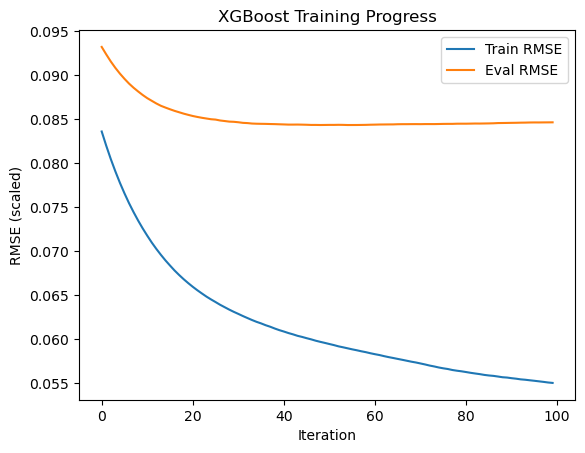

In [13]:
plot_xgb_training_curve(evals_result)

Feature Importances:
no2_lag1: 15817.0
LST_day_mean: 14590.0
NTL_mean: 13298.0
no2_neighbor_lag1: 8605.0
pop_sum_m: 5476.0
lu_residential_area: 2954.0
road_residential_len: 2625.0
road_len: 2515.0
road_primary_len: 2261.0
road_tertiary_len: 1919.0
road_secondary_len: 1655.0
cloud_category: 1521.0
lu_industrial_area: 1097.0
road_trunk_len: 866.0
landcover_2023: 763.0
lu_farmland_area: 702.0
lu_commercial_area: 560.0
lu_farmyard_area: 333.0
poi_count: 243.0
lu_retail_area: 242.0
road_motorway_len: 0
fossil_pp_count: 0


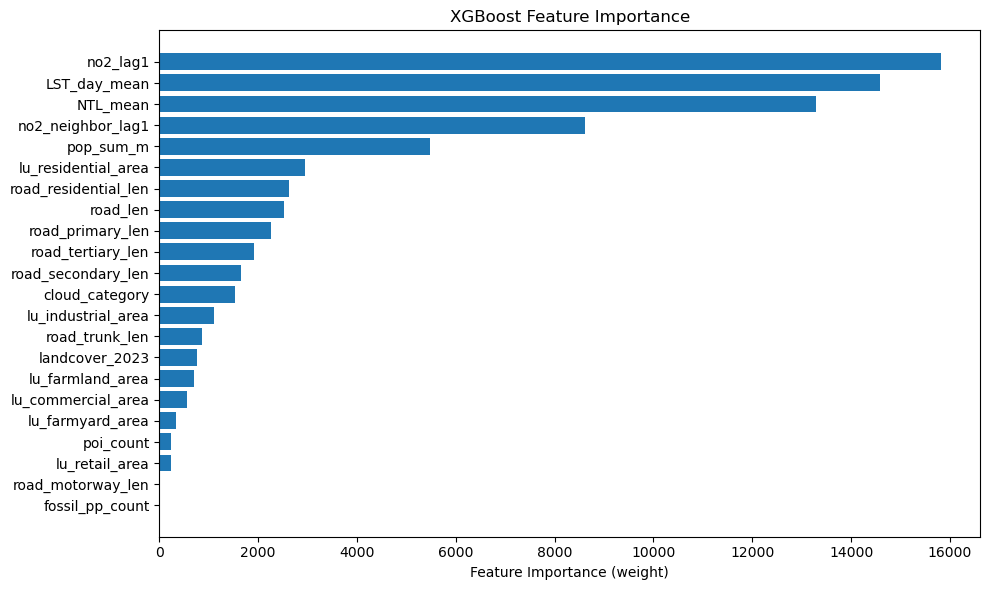

In [12]:
plot_xgb_feature_importance(bst, features)

## 2 Models for Baghdad

### 2.0 Data Preparation and Feature Selection

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
# Read the data
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")
# full_baghdad_df.describe()
# Drop NA
clean_bag_df = full_baghdad_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"])

In [35]:
# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean', 
    'temp_mean',

    # mobility data
    'TCI',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023'
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

]

target = ["no2_mean"]

X = clean_bag_df[features].values
y = clean_bag_df[target].values

In [36]:
# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel to 1D for xgboost compatibility
y_test_scaled = scaler_y.transform(y_test).ravel()


### 2.1 Random Forest Model

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np


# Define pipeline
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestRegressor(
        n_jobs=-1,
        random_state=42,
        oob_score=True,
        n_estimators=100
    ))
])

# Define simplified parameter space
param_dist = {
    "rf__max_depth":         [15], # 10
    "rf__min_samples_leaf":  [2],
    "rf__max_features":      ["sqrt"],
}

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

# Generate sampled parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=2, random_state=42))

best_score = -np.inf
best_model = None
best_params = None

print("Running randomized search with progress bar...\n")

# Randomized search with progress bar
for params in tqdm(param_list):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs=-1,
            random_state=42,
            oob_score=True,
            n_estimators=100,
            max_depth=params["rf__max_depth"],
            min_samples_leaf=params["rf__min_samples_leaf"],
            max_features=params["rf__max_features"],
        ))
    ])
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=3, scoring=rmse_scorer, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_params = params

# Fit the best model
best_model.fit(X_train_scaled, y_train_scaled)

from sklearn.metrics import root_mean_squared_error, r2_score
# evaluate results with RMSE
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running randomized search with progress bar...



100%|██████████| 1/1 [02:57<00:00, 177.85s/it]


In [ ]:
rmse = root_mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

Final RMSE: 0.05520881599791824
R square: 0.10253411864158235


: 

#### Fast SHAP on a sub-sample

In [ ]:
import shap
import pandas as pd

X_df = pd.DataFrame(X_train, columns=features)

# 1. Extract the RandomForest model from the Pipeline
rf_model = best_model.named_steps["rf"]

# 2. Background data: randomly sample a subset of the training set (DataFrame with column names)
X_bg = pd.DataFrame(X_train_scaled, columns=X_df.columns).sample(n=min(1000, len(X_train_scaled)), random_state=0)

# 3. Create the SHAP explainer
explainer = shap.TreeExplainer(rf_model, X_bg)

# 4. Convert the test set to a DataFrame with column names
X_test_df = pd.DataFrame(X_test_scaled, columns=X_df.columns)

# 5. Sample up to 1000 rows from the test set
X_test_sample = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# 6. Compute SHAP values for the sampled test set
shap_values = explainer.shap_values(X_test_sample)

# 7. Plot the SHAP summary plot (top 15 features)
shap.summary_plot(shap_values, X_test_sample, max_display=15)



##### Results for Baghdad

| Rank | Feature             | Est. mean SHAP | Direction / Interpretation          |
| ---- | ------------------- | -------------: | ----------------------------------- |
| 1    | `no2_neighbor_lag1` |     **+0.015** | Neighbour lag dominates → ↑ NO₂     |
| 2    | `no2_lag1`          |     **+0.010** | Own lag strong → ↑ NO₂              |
| 3    | `temp_mean`         |     **–0.006** | Higher temperature → ↓ NO₂          |
| 4    | `landcover_2023`    |     **–0.004** | Greener class → ↓ NO₂               |
| 5    | `TCI`               |     **–0.003** | Drier soils (blue on right) → ↑ NO₂ |


### 2.2 XGBoost Model

##### Why We Also Train XGBoost  
XGBoost **boosts** trees sequentially—each new tree learns the residuals of the current ensemble:

* Captures subtle interactions the Random Forest may under-fit.  
* Built-in *early stopping* (round ≈ 20) caps over-fit.  
* Provides an independent benchmark: agreement between RF and XGB gives management confidence.


In [ ]:
import xgboost as xgb
from analysis import plot_xgb_training_curve
from analysis import plot_xgb_feature_importance

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 100

evals_result = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False
)

# Predict on test dataset
y_pred_scaled = bst.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() # Inverse normalization to the original scale
print("Final RMSE:", mean_squared_error(y_test, y_pred, squared=False))


In [ ]:
plot_xgb_training_curve(evals_result)

In [ ]:
plot_xgb_feature_importance(bst, features)